In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, recall_score

In [2]:
df_resultados = pd.read_csv('RESULTADOS_04_06_2024_full_teste.csv', compression='gzip')
df_resultados2 = pd.read_csv('RESULTADOS_02_03_2024_full_teste.csv', compression='gzip')
df_resultados3 = pd.read_csv('RESULTADOS_06_2023_07_2023_full_teste.csv' ,compression='gzip')

In [3]:
# Remover coluna errada
df_resultados = df_resultados.drop(columns=['Unnamed: 0'], axis=1)
df_resultados2 = df_resultados2.drop(columns=['Unnamed: 0'], axis=1)
df_resultados3 = df_resultados3.drop(columns=['Unnamed: 0'], axis=1)


In [4]:
df_resultados = df_resultados.dropna()
df_resultados2 = df_resultados2.dropna()
df_resultados3 = df_resultados3.dropna()

In [5]:
# Transformando para .parquet para uma manipulação mais rápida dos dados

df_resultados.to_parquet('df_resultados.parquet', index=False)
df_resultados2.to_parquet('df_resultados2.parquet', index=False)
df_resultados3.to_parquet('df_resultados3.parquet', index=False)

In [6]:
# Limpando colunas que não serão usadas agora

colunas = ['DATA']

df_resultados2 = df_resultados2.drop(columns=colunas, axis=1)
df_resultados = df_resultados.drop(columns=colunas, axis=1)
df_resultados3 = df_resultados3.drop(columns=colunas, axis=1)

In [7]:
# Transformando os DFs de resultados em apenas um DF de resultados maior

df = pd.concat([df_resultados, df_resultados2, df_resultados3])

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['UNIT'].unique()

In [11]:
# Garantir que 'VALUE' seja convertido para tipo numérico, forçando erros (por exemplo, entradas não numéricas se tornam NaN)
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')

# Garantir que 'KNR', 'NAME' e 'UNIT' sejam strings (object está ok, mas explicitamente convertendo para string para maior clareza)
df['KNR'] = df['KNR'].astype(str)
df['NAME'] = df['NAME'].astype(str)
df['UNIT'] = df['UNIT'].astype(str)

# Garantir que 'ID' e 'STATUS' sejam inteiros
df['ID'] = df['ID'].astype(int)
df['STATUS'] = df['STATUS'].astype(int)

# 'VALUE_ID' pode permanecer como float64 ou ser convertido para inteiro se contiver apenas números inteiros
if pd.api.types.is_float_dtype(df['VALUE_ID']) and (df['VALUE_ID'] == df['VALUE_ID'].astype(int)).all():
    df['VALUE_ID'] = df['VALUE_ID'].astype(int)

In [12]:
# Remover linhas onde 'UNIT' está vazio ou é NaN
df = df[df['UNIT'].notna() & (df['UNIT'] != '')]

# Remover qualquer coluna com o nome 'Unnamed: 5'
df = df.drop(columns=[col for col in df.columns if 'Unnamed: 5' in col])

# Remover linhas onde 'UNIT' contém '\u00B0'
df = df[~df['UNIT'].str.contains(r'\\u00B0', regex=True)]

In [ ]:
# Cálculo original para status_count
status_count = df.groupby(['KNR', 'ID', 'STATUS']).size().unstack(fill_value=0)

# Pivotar a tabela para criar colunas para cada combinação de ID-STATUS
status_count = status_count.unstack(level=-1).fillna(0)

# Achatar o MultiIndex das colunas
status_count.columns = [f'{int(col[1])}_status_{int(col[0])}' for col in status_count.columns]

# Resetar o índice para trazer KNR de volta como uma coluna
status_count = status_count.reset_index()

# Agrupar por KNR e calcular a contagem de nomes únicos
unique_names = df.groupby('KNR').agg(unique_names=('NAME', 'nunique')).reset_index()

# Mesclar a contagem de nomes únicos com os status counts
resultados_id_status = pd.merge(unique_names, status_count, on='KNR')

# Agora calcular a contagem e a média de VALUE por UNIT para cada KNR
unit_stats = df.groupby(['KNR', 'UNIT']).agg(
    unit_count=('VALUE', 'size'),
    unit_mean=('VALUE', 'mean')
).reset_index()

# Pivotar o resultado para criar colunas para cada UNIT único
unit_stats_pivot = unit_stats.pivot(index='KNR', columns='UNIT', values=['unit_count', 'unit_mean']).fillna(0)

# Achatar o MultiIndex das colunas
unit_stats_pivot.columns = [f'{col[1]}_{col[0]}' for col in unit_stats_pivot.columns]

# Resetar o índice para trazer KNR de volta como uma coluna
unit_stats_pivot = unit_stats_pivot.reset_index()

# Mesclar as estatísticas de unidade com o DataFrame original resultados_id_status
final_result = pd.merge(resultados_id_status, unit_stats_pivot, on='KNR')

final_result.head()

In [ ]:
final_result.info()

In [ ]:
final_result.head()

# FALHAS

In [ ]:
falhas = pd.read_csv('falhas_modelo.csv')

In [ ]:
falhas.head()

In [18]:
falhas = falhas.drop(['DATA', 'MODELO', 'COR', 'MOTOR', 'ESTACAO', 'USUARIO', 'FALHA'], axis=1)

In [ ]:
# Primeiro, remove a coluna 'HALLE'
falhas = falhas.drop(columns=['HALLE'])

# Faz o pivot do DataFrame para criar colunas para cada S_GROUP_ID único
falhas_pivot = pd.get_dummies(falhas, columns=['S_GROUP_ID'])

# Agrupa por KNR para garantir que os valores de KNR sejam únicos, somando as variáveis dummy
falhas_grouped = falhas_pivot.groupby('KNR').sum().reset_index()

# Exibe o DataFrame transformado final
falhas_grouped


In [ ]:
# Realiza o merge com base em KNR, usando 'left' join para manter todas as linhas de resultados_id_status
merged_df = pd.merge(final_result, falhas_grouped, on='KNR', how='left')

# Preenche as colunas S_GROUP_ID faltantes com 0 onde falhas_grouped não teve KNRs correspondentes
merged_df.fillna(0, inplace=True)

# Adiciona a coluna FALHA, 1 se KNR estiver em ambos os DataFrames, caso contrário 0
merged_df['FALHA'] = merged_df['KNR'].apply(lambda x: 1 if x in falhas_grouped['KNR'].values else 0)

# Remove as linhas onde KNR está apenas em falhas_grouped (este passo agora é redundante devido ao 'left' join,
# mas pode ser adicionado se necessário para lógica adicional)
# merged_df = merged_df[merged_df['KNR'].isin(resultados_id_status['KNR'])]

# Exibe o DataFrame final
merged_df

In [ ]:
# Remover espaços no início e no final dos nomes das colunas
merged_df.columns = merged_df.columns.str.strip()

# Adicionalmente, se desejar substituir múltiplos espaços internos por um único espaço ou removê-los completamente
merged_df.columns = merged_df.columns.str.replace(r'\s+', '', regex=True)  # Substitui múltiplos espaços por um único espaço

# Opcionalmente, se desejar remover todos os espaços nos nomes das colunas
# merged_df.columns = merged_df.columns.str.replace(' ', '')

# Imprimir os nomes das colunas atualizados
print(merged_df.columns.tolist())


In [ ]:
column_list = merged_df.columns.tolist()
column_list

## Classificação Binária de Falha

In [ ]:
# Features a serem usadas para previsão
features = ['unique_names', '1_status_10', '2_status_10', '718_status_10', '1_status_13', '2_status_13', '718_status_13', '_unit_count', '%_unit_count', 'Clicks_unit_count', 'Deg_unit_count', 'Grad_unit_count', 'Nm_unit_count', 'Unnamed:5_unit_count', 'V_unit_count', 'kg_unit_count', 'min_unit_count', 'mm_unit_count', '_unit_mean', '%_unit_mean', 'Clicks_unit_mean', 'Deg_unit_mean', 'Grad_unit_mean', 'Nm_unit_mean', 'Unnamed:5_unit_mean', 'V_unit_mean', 'kg_unit_mean', 'min_unit_mean', 'mm_unit_mean']
target = 'FALHA'

# Selecionando as features e a variável alvo do DataFrame unificado
X = merged_df[features]
y = merged_df[target].values

# Garantir que `y` seja um array 1D com valores binários (0, 1)
y = y.reshape(-1)  # Achatar para garantir que seja um array 1D

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir o modelo de rede neural Keras
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train_scaled, y_train, epochs=500, batch_size=16, validation_split=0.2)

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia no Teste: {test_acc:.4f}')


# Classificação Binária com LSTM


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features e alvo
features = ['unique_names', '1_status_10', '2_status_10', '718_status_10', '1_status_13', '2_status_13', '718_status_13',
            '_unit_count', '%_unit_count', 'Clicks_unit_count', 'Deg_unit_count', 'Grad_unit_count', 'Nm_unit_count',
            'Unnamed:5_unit_count', 'V_unit_count', 'kg_unit_count', 'min_unit_count', 'mm_unit_count', '_unit_mean',
            '%_unit_mean', 'Clicks_unit_mean', 'Deg_unit_mean', 'Grad_unit_mean', 'Nm_unit_mean', 'Unnamed:5_unit_mean',
            'V_unit_mean', 'kg_unit_mean', 'min_unit_mean', 'mm_unit_mean']

target = 'FALHA'

# Seleciona as features e o alvo do DataFrame
X = merged_df[features]
y = merged_df[target].values

# Garante que `y` seja um array unidimensional
y = y.reshape(-1)

# Divide os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajusta X_train e X_test para atender ao requisito de entrada do LSTM (amostras, timesteps, features)
# Como não temos dados de séries temporais ou sequenciais, usaremos 1 timestep
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Construa o modelo LSTM
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),  # Camada LSTM
    Dense(8, activation='relu'),  # Adiciona uma camada Dense como camada oculta
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compile o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treine o modelo
model.fit(X_train_scaled, y_train, epochs=500, batch_size=16, validation_split=0.2)

# Avalie o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia no Teste: {test_acc:.4f}')


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


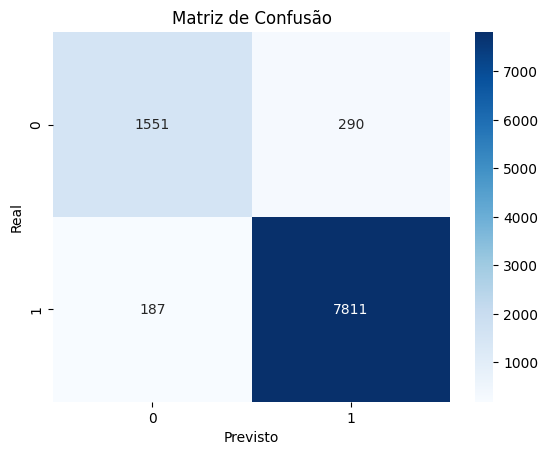

Recall: 0.9766


In [25]:
# Realizar previsões no conjunto de teste
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Calcular o recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')


In [26]:
# Avalie no conjunto de treinamento
train_loss, train_acc = model.evaluate(X_train_scaled, y_train)
print(f'Acurácia no Treinamento: {train_acc:.4f}')

# Avalie no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia no Teste: {test_acc:.4f}')


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.9674 - loss: 0.0838
Training Accuracy: 0.9635
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - accuracy: 0.9511 - loss: 0.2879
Test Accuracy: 0.9515


## Classificação Binária para cada S_GROUP_ID


In [ ]:
merges_s_group = pd.merge(final_result, falhas_grouped, on='KNR', how='inner')
merges_s_group

In [ ]:
# Features a serem usadas para previsão
features = ['unique_names', '1_status_10', '2_status_10', '718_status_10', '1_status_13', '2_status_13', '718_status_13', '_unit_count', '%_unit_count', 'Clicks_unit_count', 'Deg_unit_count', 'Grad_unit_count', 'Nm_unit_count', 'Unnamed:5_unit_count', 'V_unit_count', 'kg_unit_count', 'min_unit_count', 'mm_unit_count', '_unit_mean', '%_unit_mean', 'Clicks_unit_mean', 'Deg_unit_mean', 'Grad_unit_mean', 'Nm_unit_mean', 'Unnamed:5_unit_mean', 'V_unit_mean', 'kg_unit_mean', 'min_unit_mean', 'mm_unit_mean']
targets = ['S_GROUP_ID_-2', 'S_GROUP_ID_1', 'S_GROUP_ID_2', 'S_GROUP_ID_4', 'S_GROUP_ID_5', 'S_GROUP_ID_133', 'S_GROUP_ID_137', 'S_GROUP_ID_140', 'S_GROUP_ID_9830946', 'S_GROUP_ID_#MULTIVALUE', 'S_GROUP_ID_-2', 'S_GROUP_ID_1', 'S_GROUP_ID_133', 'S_GROUP_ID_137', 'S_GROUP_ID_140', 'S_GROUP_ID_2', 'S_GROUP_ID_4', 'S_GROUP_ID_5', 'S_GROUP_ID_9830946']

# Garante que as features e os alvos existem e não têm valores ausentes
for target in targets:
    # Verifica se a coluna do alvo existe no DataFrame
    if target not in merged_df.columns:
        print(f"Coluna do alvo {target} não encontrada no DataFrame.")
        continue

    # Seleciona as features e a coluna do alvo
    X = merged_df[features]
    y = merged_df[target]

    # Remove as linhas onde X ou y têm valores NaN
    Xy = pd.concat([X, y], axis=1).dropna()

    # Agora separa X e y após remover as linhas com valores NaN
    X_cleaned = Xy[features]
    y_cleaned = Xy[target].values

    # Garante que `y_cleaned` seja um array unidimensional
    y_cleaned = y_cleaned.reshape(-1)

    # Verifica se o número de linhas é consistente antes de prosseguir
    if len(X_cleaned) != len(y_cleaned):
        print(f"Número inconsistente de amostras para o alvo {target}. Pulando este alvo.")
        continue

    # Divide os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

    # Normaliza as features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Construa o modelo de rede neural
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile o modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treine o modelo
    model.fit(X_train_scaled, y_train, epochs=500, batch_size=16, validation_split=0.2)

    # Avalie o modelo no conjunto de teste
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
    print(f"Acurácia no Teste para {target}: {test_acc:.4f}")

In [ ]:
model.save('/caminho_completo/modelo_lstm_falha.h5')